<a href="https://www.kaggle.com/code/abhijitmishra07/moveinsync-logo-detection?scriptVersionId=126691806" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-logo-dataset/nonLogoCar.jpg
/kaggle/input/car-logo-dataset/side2.jpeg
/kaggle/input/car-logo-dataset/MoveInSync_Full.jpg
/kaggle/input/car-logo-dataset/side1.jpeg


In [2]:
! pip install opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17 keras-ocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.9 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=6f7b4e1e8d9164ef51c55e3b73a457cc8a53cc267aaa55d0344a7cf178062187
  Stored in directory: /root/.cache/pip/wheels/3d/7c/f1/f87f51d07a2513aa0fb128d5eb504da1fcef9c87475d9eef64
Successfully built validators
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-pyth

In [3]:
import numpy as np
import pandas as pd
import cv2
import keras_ocr
import math
import matplotlib.pyplot as plt

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


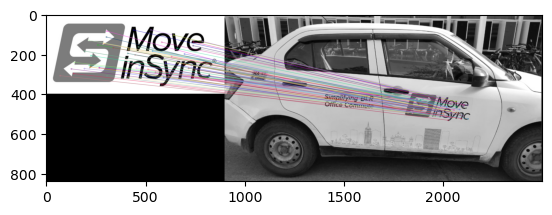

(<matplotlib.image.AxesImage at 0x7c0bf6da46d0>, None)

In [4]:
logo_img = cv2.imread('/kaggle/input/car-logo-dataset/MoveInSync_Full.jpg')
gray_logo = cv2.cvtColor(logo_img, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

kp_logo, desc_logo = sift.detectAndCompute(gray_logo, None)

img = cv2.imread('/kaggle/input/car-logo-dataset/side1.jpeg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

kp_img, desc_img = sift.detectAndCompute(gray_img, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(desc_logo, desc_img, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.5 * n.distance:
        good_matches.append([m])
        
img2 = cv2.drawMatchesKnn(gray_logo,kp_logo,gray_img,kp_img,good_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img2),plt.show()

Logo found!


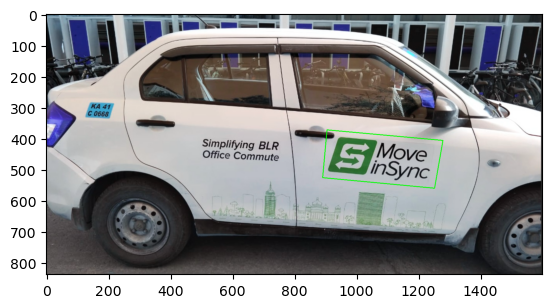

In [5]:
if len(good_matches) > 4:
    src_pts = np.float32([kp_logo[m[0].queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_img[m[0].trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    h, w = logo_img.shape[:2]
    logo_pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst_logo_pts = cv2.perspectiveTransform(logo_pts, M)
    res_img = cv2.polylines(img, [np.int32(dst_logo_pts)], True, (0, 255, 0), 2)
    print("Logo found!")
    plt.imshow(res_img),plt.show()
else:
    print("Logo not found.")

In [6]:
def length_of_longest_diag(points):
    AB = np.linalg.norm(points[1]-points[0])
    CD = np.linalg.norm(points[3]-points[2])
    AC = np.linalg.norm(points[2]-points[0])
    BD = np.linalg.norm(points[3]-points[1])
    
    d = ((max(AB**2, CD**2, AC**2, BD**2) + min(AB**2, CD**2, AC**2, BD**2) + max((AB**2 + CD**2 + AC**2 + BD**2) - max(AB**2, CD**2, AC**2, BD**2)*2, 0))/2)**0.5

    return d

1/1 [==============================] - 4s 4s/step


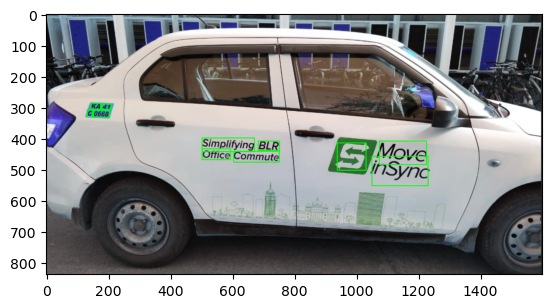

(<matplotlib.image.AxesImage at 0x7c0bce3eb7d0>, None)

In [7]:
path = '/kaggle/input/car-logo-dataset/side1.jpeg'
img = cv2.imread(path)
img_rect = img


images = [
    keras_ocr.tools.read(img) for img in [path]
]

prediction_groups = pipeline.recognize(images)

words={}

color = (0, 255, 0) # Green color
thickness = 2

for pred in prediction_groups[0]:
    words[pred[0]] = pred[1]
    img_rect = cv2.rectangle(img_rect, (pred[1][0][0],pred[1][0][1]), (pred[1][2][0],pred[1][2][1]), color, thickness)
plt.imshow(img_rect),plt.show()

In [8]:
if('move' in words and 'insync' in words):
    x_move=np.sum(words['move'][:,0])/4
    y_move=np.sum(words['move'][:,1])/4
    x_insync=np.sum(words['insync'][:,0])/4
    y_insync=np.sum(words['insync'][:,1])/4
    d = math.sqrt((x_move - x_insync)**2 + (y_move - y_insync)**2)
    if(d<(length_of_longest_diag(words['move'])+length_of_longest_diag(words['insync']))):
        print('Logo found!')
    else:
        print('Logo not found')
else:
    print('Logo not found')

Logo found!
